#### Loading and preparing the PCam data for training deep learning models using tensorflow dataset (tfds)

Loading the required libraries

In [1]:
import pathlib
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import layers, losses, models

In [2]:
# get current working directory
cwd = pathlib.Path.cwd()

In [3]:
ds1,ds2,ds3 = tfds.load('patch_camelyon',split=['train[:30%]','test[:7%]','validation[:7%]'],
                        data_dir = cwd, #'V:\\BDADShareData2\\DATA_TFDS_BDAD',
                        download=False,
                        shuffle_files=True)

# VAE

In [4]:
batch_size = 32
file_name = 'VAE_p5'

# For the autoencoder
def preprocess_for_autoencoder(sample):
    image = tf.image.convert_image_dtype(sample['image'], tf.float32)
    return image, image  # return image as both input and target

autoencoder_train_dataset = ds1.map(preprocess_for_autoencoder).batch(batch_size)
autoencoder_validation_dataset = ds2.map(preprocess_for_autoencoder).batch(batch_size)
autoencoder_test_dataset = ds3.map(preprocess_for_autoencoder).batch(batch_size)

In [5]:
"""encoder = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(96, 96, 3)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    # Double the size of latent dimension since it will be split into mean and log var
    tf.keras.layers.Dense(latent_dim * 2)
])"""

"""latent_dim = 48  # Increase the size of latent dimension if needed

encoder = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(96, 96, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=(2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(latent_dim * 2),  # Outputs for both mean and log variance
])

latent_dim = 96

encoder = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(96, 96, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(latent_dim * 2)  # Outputs for both mean and log variance
])"""

latent_dim = 48  # Set the latent dimension size

encoder = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(96, 96, 3)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(latent_dim * 2)  # Outputs for both mean and log variance
], name='encoder')


print(encoder.summary())

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 16)       64        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 96)                7077984   
                                                           

In [6]:
# Assuming the final shape before flattening in the encoder was (48, 48, 32)
"""final_conv_shape = (48, 48, 32)  # Adjust based on your encoder's architecture
decoder_input_shape = (latent_dim,)

decoder = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=decoder_input_shape),
    
    # First dense layer to unflatten the encoded representation
    tf.keras.layers.Dense(units=np.prod(final_conv_shape), activation='relu'),
    
    # Reshape to the shape before the last flatten layer in the encoder
    tf.keras.layers.Reshape(target_shape=final_conv_shape),
    
    # Conv2DTranspose layers to upsample back to the original image size
    tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),

    # The last Conv2DTranspose layer should have filters equal to the number of color channels in the output image, which is 3
    tf.keras.layers.Conv2DTranspose(16, (3, 3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),

    # Output layer with sigmoid activation to get values between 0 and 1 for image reconstruction
    tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])"""

"""
decoder = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
    tf.keras.layers.Dense(12*12*128, activation='relu'),  # This needs to be adjusted to match the encoder's last Conv2D output
    tf.keras.layers.Reshape((12, 12, 128)),  # Start shape for upsampling
    tf.keras.layers.Conv2DTranspose(128, kernel_size=(3, 3), activation='relu', padding='same', strides=(2, 2)),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), activation='relu', padding='same', strides=(2, 2)),
    tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), activation='relu', padding='same', strides=(2, 2)),
    tf.keras.layers.Conv2DTranspose(3, kernel_size=(3, 3), activation='sigmoid', padding='same')  # 3 channels for RGB
]) 

decoder = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
    tf.keras.layers.Dense(units=12*12*128, activation='relu'),
    tf.keras.layers.Reshape(target_shape=(12, 12, 128)),
    tf.keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(3, kernel_size=3, activation='sigmoid', padding='same')  # Ensure the output layer matches the input image channels
])

"""
decoder = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
    tf.keras.layers.Dense(48*48*32, activation='relu'),  # Upscale to match the feature map size before the last Conv2D layer in the encoder
    tf.keras.layers.Reshape((48, 48, 32)),
    tf.keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')  # Output layer to reconstruct the original image
], name='decoder')


print(decoder.summary())


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 73728)             3612672   
                                                                 
 reshape (Reshape)           (None, 48, 48, 32)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 96, 96, 32)       9248      
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 96, 96, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 3)         867 

In [7]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.latent_dim = latent_dim

    def encode(self, x):
        encoder_output = self.encoder(x)
        mean, logvar = tf.split(encoder_output, num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z):
        return self.decoder(z)
    
    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z)


In [8]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-0.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


In [9]:
""" 
In the custom schedule:
- `initial_learning_rate` is the starting learning rate.
- `decay_rate` is the amount by which the learning rate is reduced.
- `decay_steps` is the number of steps over which the initial learning rate is reduced by `decay_rate`.

You can adjust the custom learning rate schedule based on your training needs, changing the formula inside the `__call__` method to implement the decay logic you desire.

Now, with the optimizer using this learning rate schedule, it will be applied automatically at each optimization step in your training loop. Remember to monitor the learning rate during training to ensure it behaves as expected.
"""

initial_learning_rate = 1e-4

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Initialize your VAE model
vae = VAE(latent_dim, encoder, decoder)

# Training step function
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


In [10]:
import time

# Training loop
vae_epochs = 50  # Adjust the number of epochs as needed
best_val_loss = float('inf')

start_time = time.time()

# Lists to store the losses
train_losses = []
val_losses = []

# Open a file to write the training history
with open(f'{file_name}_history.csv', 'w') as file:
    file.write('Epoch,Training Loss,Validation Loss\n')  # Write the header

    # Training loop
    num_epochs = vae_epochs  # Adjust the number of epochs as needed
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        print(f"Epoch: {epoch+1}")
        total_loss = 0
        for x_batch_train, _ in autoencoder_train_dataset:
            loss = train_step(vae, x_batch_train, optimizer)
            total_loss += loss.numpy()  # Convert tensor to numpy if it's not already

        avg_train_loss = total_loss / len(autoencoder_train_dataset)

        # Validation step
        total_val_loss = 0
        for x_batch_val, _ in autoencoder_validation_dataset:
            val_loss = compute_loss(vae, x_batch_val)
            total_val_loss += val_loss.numpy()  # Convert tensor to numpy if it's not already

        avg_val_loss = total_val_loss / len(autoencoder_validation_dataset)

        # Record the end time of the epoch and calculate the duration
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time

        print(f'epoch duration: {epoch_duration}')
        
        # Write epoch details to the CSV file
        file.write(f"{epoch + 1},{avg_train_loss:.4f},{avg_val_loss:.4f}\n")

        print(f"Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        # save for plotting:
        # Store the average losses for later plotting
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
    
        # Save the model if the validation loss has improved
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            vae.save_weights('final_vae_weights.h5')

# Record the end time of the entire training
end_time = time.time()
total_training_time = end_time - start_time

# Optionally, append the total training time to the CSV
with open(f'{file_name}_history.csv', 'a') as file:
    file.write(f"\nTotal training time,{total_training_time:.2f} seconds\n")

print(f"Total training time: {total_training_time:.2f} seconds")

Epoch: 1
epoch duration: 363.8161609172821
Training Loss: 16945.3855, Validation Loss: 16902.7670
Epoch: 2
epoch duration: 359.56797909736633
Training Loss: 16735.8268, Validation Loss: 16846.2422
Epoch: 3
epoch duration: 359.41920280456543
Training Loss: 16699.0673, Validation Loss: 16810.2386
Epoch: 4
epoch duration: 357.24266052246094
Training Loss: 16669.6067, Validation Loss: 16786.0923
Epoch: 5
epoch duration: 357.5048441886902
Training Loss: 16651.9362, Validation Loss: 16776.8253
Epoch: 6
epoch duration: 356.2311632633209
Training Loss: 16644.8457, Validation Loss: 16774.4884
Epoch: 7
epoch duration: 355.9144923686981
Training Loss: 16641.7214, Validation Loss: 16770.6913
Epoch: 8
epoch duration: 355.83116149902344
Training Loss: 16638.8956, Validation Loss: 16769.9444
Epoch: 9
epoch duration: 358.598575592041
Training Loss: 16636.3753, Validation Loss: 16769.4527
Epoch: 10
epoch duration: 357.41619348526
Training Loss: 16634.1713, Validation Loss: 16768.3678
Epoch: 11
epoch du

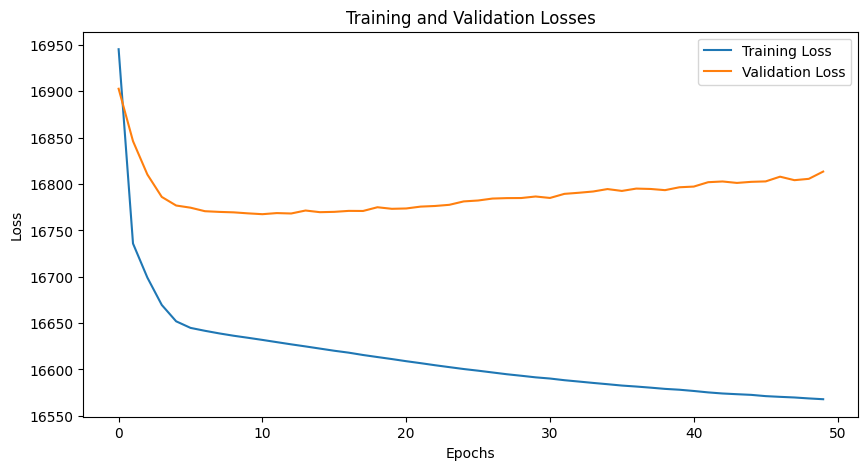

In [11]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig(f'{file_name}_training_validation_loss_plot.png')
plt.show()


1/1 [==============================] - 0s 205ms/step


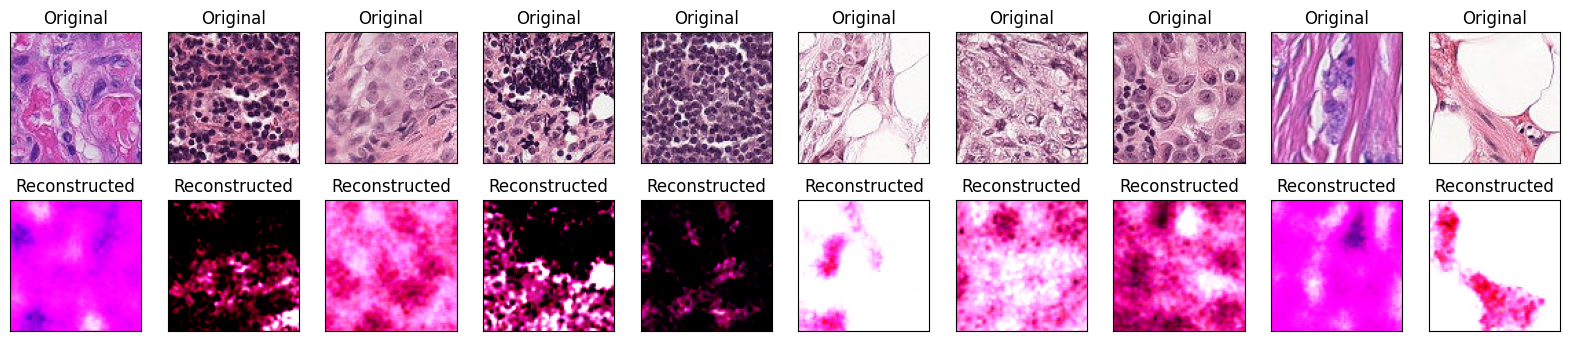

In [12]:
# Take one batch of images from the dataset
for original_images, _ in autoencoder_train_dataset.take(1):
    break

# Get reconstructed images from the autoencoder
reconstructed_images = vae.predict(original_images)

# Define how many images you want to display
n = 10  # for example, display 10 images

plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(original_images[i])
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i])
    plt.title("Reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.savefig(f'{file_name}_images_compare.png')
plt.show()
plt.close()

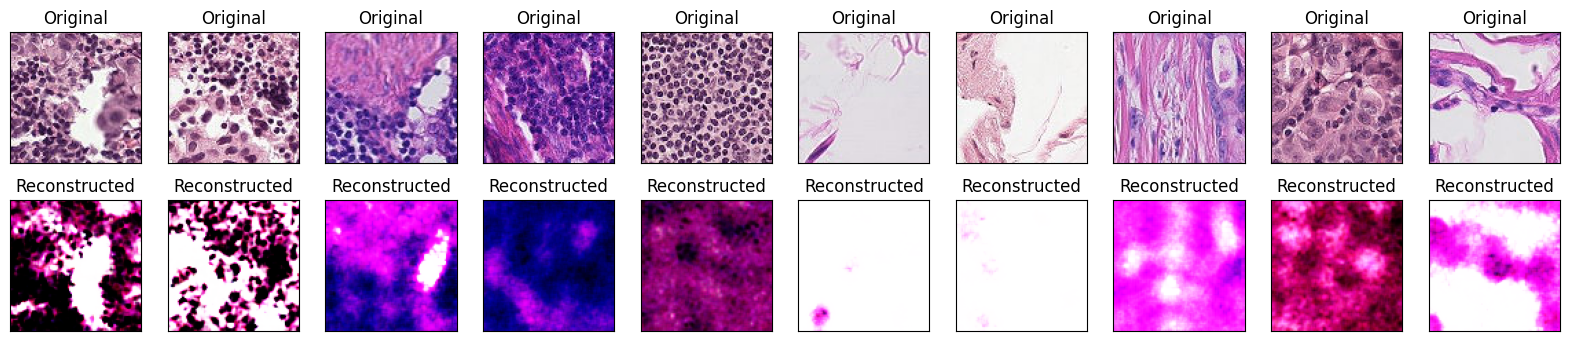

In [13]:
# Take one batch of images from the dataset
for original_images, _ in autoencoder_train_dataset.take(1):
    break

# Get reconstructed images from the VAE
reconstructed_images = vae(original_images).numpy()  

# Define how many images you want to display
n = 10  # Adjust as needed

plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(original_images[i].numpy().squeeze())
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].squeeze())
    plt.title("Reconstructed")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.savefig(f'{file_name}_images_compare_2.png')
plt.show()


In [14]:
encoder.save(f'{file_name}_encoder.h5')

# For cnn

In [17]:
encoder=tf.keras.models.load_model('VAE_p5_encoder.h5')

In [18]:
num_classes = 2

def preprocess_encode_and_label(sample):
    # Preprocess the image
    image = tf.image.convert_image_dtype(sample['image'], tf.float32)
    image = tf.image.resize(image, [96, 96])

    # Add a batch dimension
    image = tf.expand_dims(image, 0)

    # Encode the image using the trained encoder
    encoded_image = encoder(image, training=False)
    print(encoder.summary())

    # Remove the batch dimension
    encoded_image = tf.squeeze(encoded_image, 0)

    # One-hot encode the label
    label = tf.one_hot(sample['label'], num_classes, dtype=tf.float32)

    return encoded_image, label

# Apply the function to your datasets
encoded_classifier_train_dataset = ds1.map(preprocess_encode_and_label).batch(batch_size)
encoded_classifier_val_dataset = ds2.map(preprocess_encode_and_label).batch(batch_size)
encoded_classifier_test_dataset = ds3.map(preprocess_encode_and_label).batch(batch_size)


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 16)       64        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 96)                7077984   
                                                           

Train a new CNN

In [21]:
latent_dim = 48  # Ensure this matches the latent_dim used in your VAE encoder
num_classes = 2  # Adjust this according to your specific problem
file_name = "VAE_p10"

# Define a simple neural network model for classification
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(latent_dim * 2,)),  # The input shape should match the VAE encoder output
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Use 'softmax' for multi-class classification
])

cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',  # or 'binary_crossentropy' for binary classification
                  metrics=['accuracy'])

# Train the CNN on the new dataset
epochs_cnn = 55  # Adjust the number of epochs as needed

from tensorflow.keras.callbacks import EarlyStopping

# Initialize early stopping
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# Train the model with the early stopping callback
history = cnn_model.fit(
    encoded_classifier_train_dataset,
    validation_data=encoded_classifier_val_dataset,
    epochs=epochs_cnn,
    callbacks=[early_stopping_callback]  # Add early stopping callback here
)

# history = cnn_model.fit(encoded_classifier_train_dataset, validation_data=encoded_classifier_val_dataset, epochs=epochs_cnn)

Epoch 1/55
2458/2458 [==============================] - 507s 206ms/step - loss: 0.5373 - accuracy: 0.7275 - val_loss: 0.5855 - val_accuracy: 0.6918
Epoch 2/55
2458/2458 [==============================] - 493s 201ms/step - loss: 0.4987 - accuracy: 0.7561 - val_loss: 0.5544 - val_accuracy: 0.7219
Epoch 3/55
2458/2458 [==============================] - 490s 199ms/step - loss: 0.4854 - accuracy: 0.7646 - val_loss: 0.5469 - val_accuracy: 0.7271
Epoch 4/55
2458/2458 [==============================] - 500s 203ms/step - loss: 0.4755 - accuracy: 0.7702 - val_loss: 0.5691 - val_accuracy: 0.7127
Epoch 5/55
2458/2458 [==============================] - 486s 198ms/step - loss: 0.4678 - accuracy: 0.7743 - val_loss: 0.5914 - val_accuracy: 0.7119
Epoch 6/55
2458/2458 [==============================] - 477s 194ms/step - loss: 0.4579 - accuracy: 0.7808 - val_loss: 0.6158 - val_accuracy: 0.7036
Epoch 7/55
2458/2458 [==============================] - 486s 198ms/step - loss: 0.4503 - accuracy: 0.7850 - val_

In [22]:
# Convert the history.history dict to a pandas DataFrame
hist_df = pd.DataFrame(history.history)

# Save to csv
hist_df.to_csv(f'{file_name}_history.csv')


In [23]:
predictions = cnn_model.predict(encoded_classifier_test_dataset)

predictions = np.argmax(predictions, axis=1)

predictions_pd = pd.DataFrame({
    'Id': list(range(len(predictions))),
    'Predicted': predictions.reshape(-1,),
})

predictions_pd.to_csv(f'{file_name}_predictions.csv', index=False)

72/72 [==============================] - 14s 190ms/step


In [24]:
# Assuming the encoded_test_dataset is already batched and prefetched
true_labels = []
for images, labels in encoded_classifier_test_dataset.unbatch().take(len(predictions)):
    true_labels.append(labels.numpy())

# Convert the true labels to a numpy array
true_labels = np.array(true_labels)

# If true_labels is one-hot encoded, convert it to class indices
true_labels = np.argmax(true_labels, axis=1)

# Generate predictions
predictions = cnn_model.predict(encoded_classifier_test_dataset)

# If predictions are probabilities, use argmax to get predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the accuracy
accuracy = np.mean(predicted_labels == true_labels)
my_string = f"Accuracy: {accuracy * 100:.2f}%"
print(my_string)

# Open the file in write mode ('w') and write the string to it
with open(f'{file_name}_accuracy.csv', 'w') as file:
    file.write(my_string)

72/72 [==============================] - 14s 196ms/step
Accuracy: 75.37%


# Consider: 
which metric to use to save the best model
why use lowest ELBO? 
Why not based on validation loss or some alternative metric?

Consider if we should Binarize the data, so it's easier to model 
